# XAI Laboratory 01 - Tabular Methods

For this practice, you will need the following dataset:

- **fifa**: regression dataset containing FIFA players data:
    - short_name: name of the player
    - nationality
    - overall: overall score of the player (potential output)
    - potential: potential score of the player (potential output)
    - wage_eur: contract cancellation fine of the player (potential output)
    - value_eur: value in euros of the player (potential output)
    - age: age of the player in years
    - height_cm: height of the player in cm
    - weight_kg: weight of the player in kg
    - attacking_skills: several variables related to attacking
    - defending_skills: several variables related to defending
    - goalkeeping_skills: several variables related to goalkeeping

Use what you have learned from the `tabular_explanation.ipynb` notebook to complete the questions.

In [1]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# XAI
import shap
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

In [2]:
### Load file --------------------------------------------
df = pd.read_csv('../data/fifa.csv')
df.head()

,short_name,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,...,88,91,34,27,22,11,12,6,8,8


In [3]:
X = df.drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
y = df['value_eur']

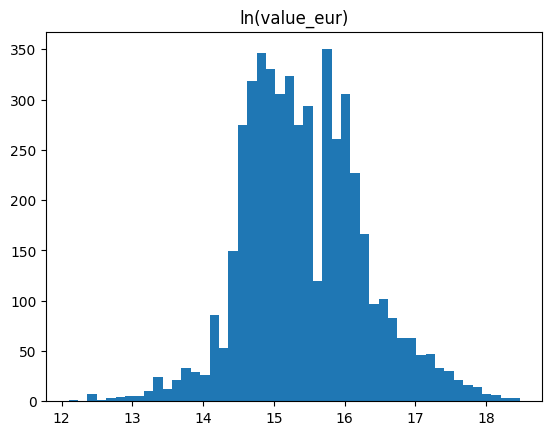

In [4]:
# Change scale of output variable
ylog = np.log(y)

plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

In [5]:
X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=42)

In [6]:
# Train XGBoost model, may take a few minutes
model = XGBRegressor()
model.fit(X_train, ylog_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [7]:
def predict_function(model, data):
    """Predict wrapper: original model was trained on log-output; return exp(pred) to recover original scale."""
    return np.exp(model.predict(data))

---
Ex 1. Ensure your model is not overfitted

In [8]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

train_pred = predict_function(model, X_train)
test_pred = predict_function(model, X_test)

train_rmse = np.square(mean_absolute_error(y_train, train_pred))
test_rmse = np.square(mean_absolute_error(y_test, test_pred))

train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train R2: {train_r2:.2f}, Test R2: {test_r2:.2f}")

Train RMSE: 40725357942.08, Test RMSE: 2155110016997.12
Train R2: 1.00, Test R2: 0.88


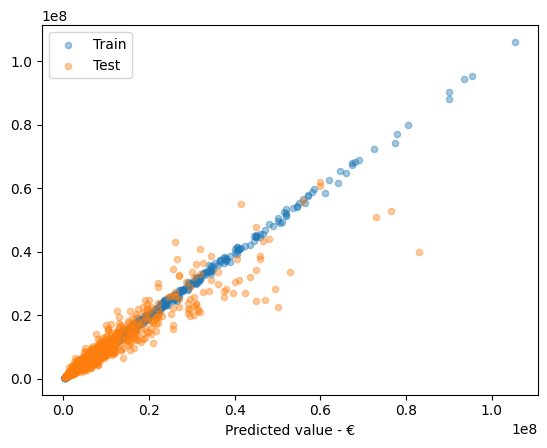

In [9]:
plt.scatter(y_train, train_pred, alpha=0.4, s=20, label="Train")
plt.scatter(y_test, test_pred, alpha=0.4, s=20, label="Test")
plt.xlabel("True value - €")
plt.xlabel("Predicted value - €")
plt.legend()
plt.show()

**English** - The model demonstrates strong performance and does not appear to be overfitting. Although the training R² is perfect (1.00) and the test R² slightly lower (0.88), this difference remains acceptable. The RMSE values are of the same order of magnitude, suggesting good generalization ability. In the scatter plot, the test predictions closely follow the diagonal, showing that the model captures the underlying relationship well. However, a few high-value outliers are not predicted as accurately, which is expected for this type of data.

**Español** - El modelo muestra un rendimiento muy sólido y no parece estar sobreajustado, ya que, aunque el R² de entrenamiento es perfecto (1.00) y el de prueba algo menor (0.88), la diferencia sigue siendo razonable. Los valores de RMSE son del mismo orden de magnitud, lo que indica una buena capacidad de generalización. En el gráfico, las predicciones del conjunto de prueba siguen de forma clara la diagonal, evidenciando que el modelo captura correctamente la relación entre las variables. No obstante, se observan algunos valores atípicos de alta magnitud que no son predichos con tanta precisión, algo esperable en este tipo de datos.

---
Ex 2. Obtain and plot variable importance measures using the following variable groups

In [10]:
variable_groups = {
    'age': ['age'],
    'body': ['height_cm', 'weight_kg'],
    'attacking': ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys'],
    'skill': ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control'],
    'movement': ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance'],
    'power': ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots'],
    'mentality': ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure'],
    'defending': ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle'],
    'goalkeeping' : ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
}

In [11]:
permut_imp = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

grop_scores = {}

for group, features in variable_groups.items():
    grop_scores[group] = np.mean([permut_imp.importances_mean[X.columns.get_loc(feat)] for feat in features])

grop_scores = pd.DataFrame.from_dict(grop_scores, orient='index', columns=['Importance']).sort_values(by='Importance', ascending=False)

grop_scores.head(10)

,Importance
age,1.413823e-08
attacking,1.143125e-08
defending,8.845668e-09
skill,8.455662e-09
movement,8.070810e-09
goalkeeping,6.161745e-09
mentality,4.348619e-09
power,3.836440e-09
body,-4.470398e-11


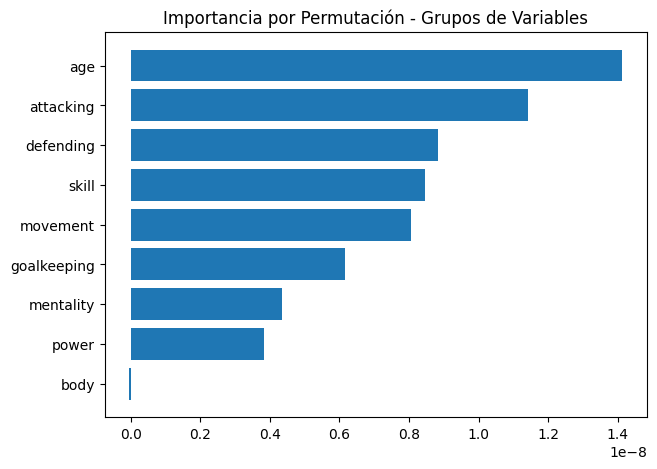

In [12]:
plt.figure(figsize=(7,5))
plt.barh(grop_scores.index[::-1], grop_scores['Importance'][::-1])
plt.title("Importancia por Permutación - Grupos de Variables")
plt.show()

---
Ex 3. Obtain which is the variable with higher influence in Leo Messi's value. Justify which algorithm you choose

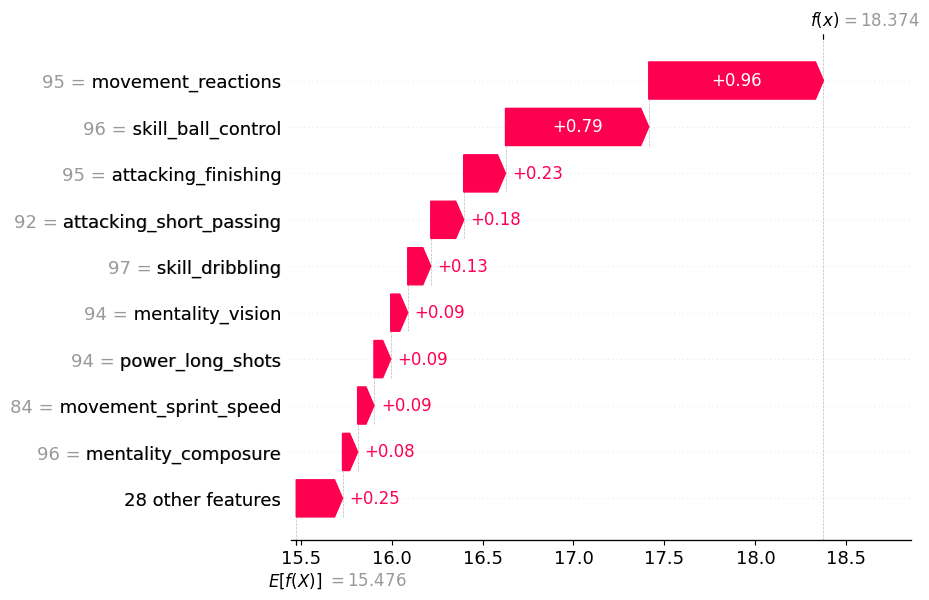

In [13]:
messi_data = df[df["short_name"].str.contains("Messi")][X.columns]

explainer = shap.TreeExplainer(model, X_train) # Use training data as background for SHAP
shap_values = explainer(messi_data) # Compute SHAP values for Messi

shap.plots.waterfall(shap_values[0])

**English** - The SHAP analysis clearly shows how each feature contributes to Messi’s final prediction compared to the baseline. The most influential variable in this case is "movement_reactions", which increases the predicted value by nearly +1, far more than any other feature. This suggests that Messi’s quick reactions are a decisive factor for the model when estimating his overall score. Other important features such as "skill_ball_control", reinforcing the model’s interpretation that technical precision and finishing ability strongly enhance performance. Overall, SHAP provides a transparent, instance-level explanation of why Messi obtains such a high rating.

**Español** - El análisis con SHAP muestra de forma clara cómo cada variable contribuye a la predicción final de Messi en comparación con el valor base. La característica más influyente en este caso es "movement_reactions", que aumenta la predicción en casi +1, mucho más que cualquier otra. Esto sugiere que las reacciones rápidas de Messi son un factor decisivo para el modelo al estimar su valoración general. Otras variables importantes como "skill_ball_control", reforzando la interpretación del modelo de que la precisión técnica y la capacidad de definición mejoran notablemente el rendimiento. En conjunto, SHAP ofrece una explicación transparente y detallada a nivel individual sobre por qué Messi obtiene una valoración tan alta.

---
Ex 4. Explain how perturbating the `height_cm` variable affect the value of Cristiano Ronaldo

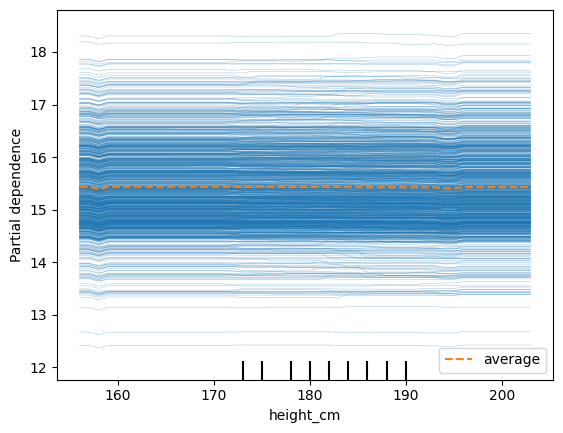

In [14]:
cr7_data = df[df["short_name"].str.contains("Ronaldo")][X.columns][0:1]
PartialDependenceDisplay.from_estimator(model, X, ["height_cm"], kind='both')

**English** - Applying a Partial Dependence Plot (PDP) to observe how the prediction changes when varying the "height_cm" feature across its possible range. The predicted value for Cristiano Ronaldo remains almost constant for all height values, suggesting that the model’s output is not significantly influenced by this variable.

**Español** - Aplicando un gráfico de dependencia parcial (PDP) para analizar cómo cambia la predicción al modificar la variable "height_cm" a lo largo de su rango posible. El valor predicho para Cristiano Ronaldo se mantiene prácticamente constante para todas las alturas, lo que sugiere que la salida del modelo no está influenciada de forma significativa por esta variable.

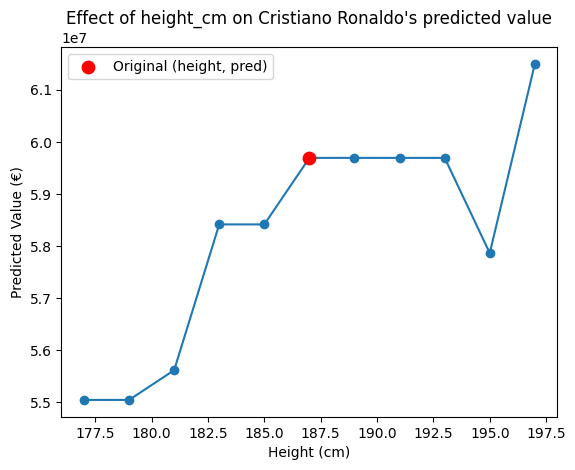

In [15]:
import numpy as np

y_pred_base = predict_function(model, cr7_data)[0]

heights = np.linspace(cr7_data["height_cm"].values[0] - 10, cr7_data["height_cm"].values[0] + 10, 11)
preds = []

for h in heights:
    modified = cr7_data.copy()
    modified["height_cm"] = h
    preds.append(predict_function(model, modified)[0])

import matplotlib.pyplot as plt
plt.plot(heights, preds, marker="o")
plt.scatter([cr7_data["height_cm"].values[0]], [y_pred_base], color='r', s=80, zorder=5, label='Original (height, pred)')
plt.xlabel("Height (cm)")
plt.ylabel("Predicted Value (€)")
plt.title("Effect of height_cm on Cristiano Ronaldo's predicted value")
plt.legend()
plt.show()


**English** - When the "height_cm" variable is perturbed around its original value, the model’s prediction for Cristiano Ronaldo remains nearly constant within a very narrow range. This suggests that height has little to no impact on his estimated value. Although some minor fluctuations appear, they likely reflect model noise rather than a genuine dependency. Overall, the model does not treat height as a key factor influencing Ronaldo’s predicted value.

**Español** - Al modificar la variable "height_cm" alrededor de su valor original, la predicción del modelo para Cristiano Ronaldo apenas cambia, manteniéndose dentro de un rango muy estrecho. Esto sugiere que la estatura no tiene un impacto relevante sobre su valoración estimada. Aunque se observan pequeñas variaciones, estas parecen deberse a fluctuaciones del modelo y no a una dependencia real. En conclusión, el modelo no considera la altura como un factor determinante en la predicción del valor de Ronaldo.

---
Ex 5. Explain the average effect of the `age` variable on the model predictions. Does it differ greatly along the samples in the dataset? Which should be more affected by perturbating this variable, the goalkeepers or the strikers?

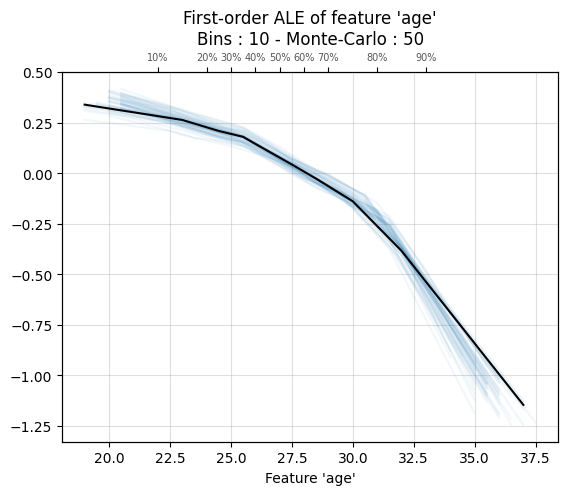

<Axes: title={'center': "First-order ALE of feature 'age'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'age'">

In [16]:
# ALE Plot for 'age' feature
ale_plot(model, X_train, 'age', monte_carlo=True)

ALE Plot for 'age' feature - Goalkeepers (467)


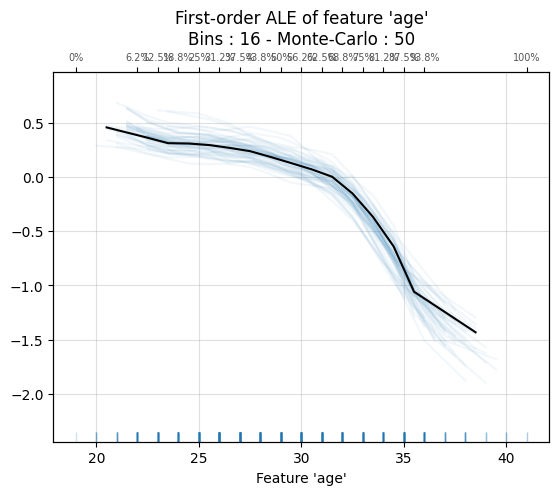

ALE Plot for 'age' feature - Defenders (2377)


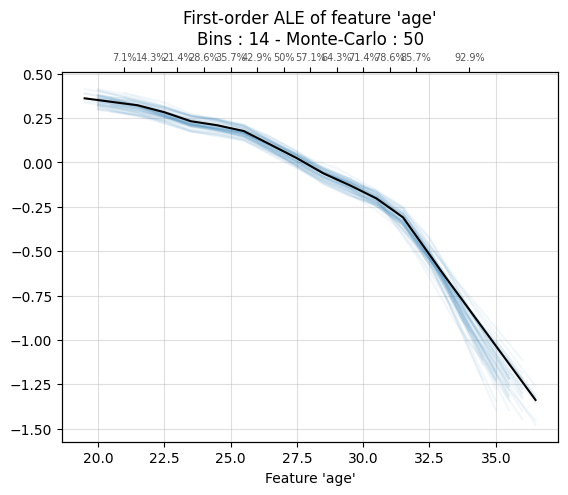

ALE Plot for 'age' feature - Attackers (2156)


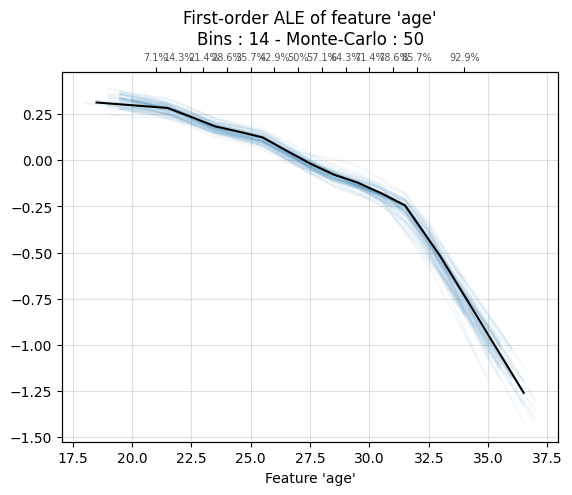

<Axes: title={'center': "First-order ALE of feature 'age'\nBins : 14 - Monte-Carlo : 50"}, xlabel="Feature 'age'">

In [17]:
goalkeeper_cols = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
attacker_cols = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys']
defender_cols = ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle']

df['attacker_mean'] = df[attacker_cols].mean(axis=1)
df['goalkeeper_mean'] = df[goalkeeper_cols].mean(axis=1)
df['defender_mean'] = df[defender_cols].mean(axis=1)

# --- Player classification ---
def classify_player(row):
    means = {
        "Attacker": row["attacker_mean"],
        "Defender": row["defender_mean"],
        "Goalkeeper": row["goalkeeper_mean"]
    }
    # Return the category with the highest mean
    return max(means, key=means.get)

df["player_role"] = df.apply(classify_player, axis=1)

gk_mask = df["player_role"] == "Goalkeeper"
df_mask_gk = df.loc[gk_mask, X.columns].dropna(subset=["age"])

def_mask = df["player_role"] == "Defender"
df_mask_def = df.loc[def_mask, X.columns].dropna(subset=["age"])

att_mask = df["player_role"] == "Attacker"
df_mask_att = df.loc[att_mask, X.columns].dropna(subset=["age"])

print(f"ALE Plot for 'age' feature - Goalkeepers ({len(df_mask_gk)})")
ale_plot(model, df_mask_gk,  'age', bins=20, monte_carlo=True)

print(f"ALE Plot for 'age' feature - Defenders ({len(df_mask_def)})")
ale_plot(model, df_mask_def, 'age', bins=20, monte_carlo=True)

print(f"ALE Plot for 'age' feature - Attackers ({len(df_mask_att)})")
ale_plot(model, df_mask_att, 'age', bins=20, monte_carlo=True)

**English** - ALE plots show that the effect of age on the predicted value is clearly negative after around 30 years old for all positions. In every case (goalkeepers, defenders, and attackers), younger players receive higher predicted values, while older ones are progressively penalized.

The magnitude of the decline differs across positions:
- Goalkeepers: the decrease is slower and starts later, remaining slightly positive up to about 30 years. The model assumes that goalkeepers maintain their performance for longer.
- Defenders: show a similar trend, but the negative slope appears a bit earlier, around 28–30 years.
- Attackers: are the most affected by age, with a sharp decline after 27–28 years. The model links aging to a quicker loss in value, consistent with how physical ability and speed are key for these roles.

Overall, the model captures a realistic pattern: players between 20 and 28 years old reach their highest predicted value, while older players tend to lose value — particularly the attackers.

**Español** - El efecto de la edad sobre el valor predicho es claramente negativo a partir de los 30 años en todas las posiciones. En las tres gráficas (porteros, defensores y atacantes), el modelo asigna valores más altos a los jugadores jóvenes y comienza a penalizar de forma progresiva conforme aumenta la edad.

Se aprecian diferencias en la intensidad del descenso:
- Porteros (Goalkeepers): la caída es más suave y se retrasa, manteniendo un efecto positivo hasta aproximadamente los 30 años. Esto sugiere que el modelo asume que los porteros conservan su rendimiento durante más tiempo.
- Defensores (Defenders): muestran un patrón similar, aunque la pendiente negativa aparece algo antes, alrededor de los 28–30 años.
- Atacantes (Attackers): son los más afectados por la edad, con un descenso pronunciado después de los 27–28 años. El modelo asocia una pérdida de valor más temprana y rápida, coherente con la importancia del físico y la velocidad en esas posiciones.

En conjunto, el modelo refleja un patrón realista: los jugadores más jóvenes (20–28 años) son los que alcanzan los valores máximos, mientras que los más veteranos tienden a perder valor, especialmente los delanteros.

---
Ex 6. Explain the prediction made for Hazard using a local surrogate model (Lime)

In [21]:
# LIME explanation
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode='regression',
    kernel_width=3
)

# Select a player to explain
hazard_data = df[df["short_name"].str.contains("Hazard")][X.columns].values[0]

# Explain the prediction using LIME
exp = explainer.explain_instance(hazard_data, model.predict)

# Show the explanation
from IPython.display import HTML

custom_style = """
<div style="background-color:white; color:black; padding:10px; border-radius:10px">
{}
</div>
""".format(exp.as_html())

HTML(custom_style)


**English** - LIME explanation shows that "movement_reactions" has the strongest positive impact on Hazard’s predicted value. Other technical skills like ball control and short passing also raise the prediction, while the low value of "defending_standing_tackle" slightly decreases it. LIME provides a local, instance-specific view of the model’s behavior, explaining why the prediction for Hazard is high but not generalizable to all players.

**Español** - LIME indica que "movement_reactions" es la variable que más impulsa el valor predicho de Hazard. Otras habilidades técnicas como ball control y short passing también lo aumentan, mientras que el bajo "defending_standing_tackle" lo reduce ligeramente. LIME ofrece una visión local y específica del modelo, explicando por qué la predicción de Hazard es alta sin que sus conclusiones sean generalizables al resto de jugadores.